In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
from fastai import *
from fastai.vision import *

# Faces

## Setup

Download the dataset [here](https://download.pytorch.org/tutorial/faces.zip) from the pytoch tutorial on transforms. Unzip it in the data directory, so that data/faces/ contains the images and the csv file.

In [ ]:
PATH = Path('../../data/faces/')
img_fns = get_image_files(PATH)
len(img_fns)

69

In [ ]:
poses = pd.read_csv(PATH/'face_landmarks.csv')
poses.head()

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516


In [ ]:
pose_dict = {o[0]:o[1:].astype(np.float32) for o in poses.values}

Reading the coordinates. We will adopt the pytorch convention in grid_sampler where the coordinates are normalized between -1 and 1. (-1,-1) is the top left corner, (1,1) the bottom right. This function scales or unscales the coordinates to that purpose 

In [ ]:
def scale_coords(x, size, to_unit=True):
    s = tensor([size[1]/2,size[0]/2])[None]
    return (x/s-1) if to_unit else ((x+1)*s)

In [ ]:
pose_pnts = []
for i, fname in enumerate(img_fns):
    size = open_image(fname).size
    coords = tensor(pose_dict[fname.name]).view(-1,2)
    pose_pnts.append(coords)

In [ ]:
len(pose_pnts)

69

In [ ]:
pose_pnts[0].shape,pose_pnts[0][0]

(torch.Size([68, 2]), tensor([ -8., 339.]))

Let's have a look at the data.

In [ ]:
def show_pose(img, pnts, ax=None):
    if ax is None: _,ax = plt.subplots()
    img.show(ax=ax, hide_axis=False)
    ax.scatter(pnts[:, 0], pnts[:, 1], s=10, marker='.', c='r')

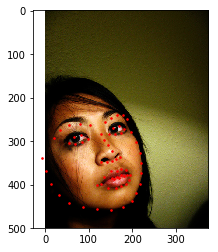

In [ ]:
img = open_image(img_fns[0])
show_pose(img, pose_pnts[0])

## ImagePoints

So when we change the picture, the points must be changed accordingly. Let's use a subclass of Image to deal with that.

In [ ]:
def _affine_inv_mult(c,m, shape):
    "Applies the inverse affine transform described in m"
    size = c.size()
    _,h,w = shape
    m[0,1] *= h/w
    m[1,0] *= w/h
    c = c.view(-1,2)
    a = torch.inverse(m[:2,:2].t()) 
    c = torch.addmm(-torch.mv(a,m[:2,2]), c, a) 
    return c.view(size)

Note: subclassing `ImageBase` and not `Image` because we end rewriting every method except `affine` and `affine_mat`. Not sure  if we should subclass `Image` (this approach raises an error if we attempt to access `px` though).

In [ ]:
class ImagePoints(ImageBase):
    "Support applying transforms to image data."
    def __init__(self, flow:Tensor, size:Tuple[int,int], scale:bool=True):
        "Create from raw tensor image data `px`."
        if scale: flow = scale_coords(flow, img.size)
        self._flow = as_tensor(flow)
        self._size = size
        self._affine_mat=None
        self.sample_kwargs = {}
        self.transformed=False

    def clone(self):
        "Mimic the behavior of torch.clone for `Image` objects."
        return self.__class__(self.flow.clone(), self.size, scale=False)

    @property
    def shape(self)->Tuple[int,int,int]: return (1, *self._size)
    @property
    def size(self)->Tuple[int,int]: return self._size
    @size.setter
    def size(self, sz:int): self._size=sz
    @property
    def device(self)->torch.device: return self._flow.device

    def __repr__(self): return f'{self.__class__.__name__} {tuple(self.size)}'
    
    @property
    def flow(self)->FlowField:
        "Access the flow-field grid after applying queued affine transforms."
        if self._flow is None:
            self._flow = _affine_grid(self.shape)
        if self._affine_mat is not None:
            self._flow = _affine_inv_mult(self._flow, self._affine_mat, self.shape)
            self._affine_mat = None
            self.transformed = True
        return self._flow
    
    @flow.setter
    def flow(self,v:FlowField):  self._flow=v
    
    def coord(self, func:CoordFunc, *args, **kwargs)->'Image':
        "Equivalent to `image.flow = func(image.flow, image.size)`."
        if 'invert' in kwargs: kwargs['invert'] = True
        self.flow = func(self.flow, self.shape, *args, **kwargs)
        self.transformed = True
        return self
    
    def affine(self, func:AffineFunc, *args, **kwargs)->'Image':
        "Equivalent to `image.affine_mat = image.affine_mat @ func()`."
        m = tensor(func(*args, **kwargs)).to(self.device)
        self.affine_mat = self.affine_mat @ m
        return self

    def lighting(self, func:LightingFunc, *args:Any, **kwargs:Any)->'Image': return self

    def pixel(self, func:PixelFunc, *args, **kwargs)->'Image':
        "Equivalent to `image.flow = func_flow(image.flow)`."
        if func.__name__ + '_coord' in globals():
            self = globals()[func.__name__ + '_coord'](self, *args, **kwargs)
        else: warn(f'{func.__name__} is not implemented for ImagePoints')
        return self
    
    def refresh(self):
        return self
    
    def resize(self, size:Union[int,TensorImageSize]):
        "Resize the image to `size`, size can be a single int."
        if isinstance(size, int): size=(1, size, size)
        #self.flow.mul_(torch.tensor([size[2]/self._size[1], size[1]/self._size[0]])[None])
        self._size = size[1:]
        return self
    
    @property
    def affine_mat(self)->AffineMatrix:
        "Get the affine matrix that will be applied by `refresh`."
        if self._affine_mat is None:
            self._affine_mat = torch.eye(3).to(self.device)
        return self._affine_mat
    @affine_mat.setter
    def affine_mat(self,v)->None: self._affine_mat=v
    
    @property
    def data(self)->TensorImage:
        "Return this images pixels as a tensor."
        flow = self.flow #This updates flow before we test if some transforms happened
        if self.transformed:
            if 'remove_out' not in self.sample_kwargs or self.sample_kwargs['remove_out']:
                flow = _remove_points_out(flow)
            self.transformed=False
        #    flow = _pad_coords(flow, **self.sample_kwargs)
        #    self.sample_kwargs,self.transformed = {},False
        return flow
    
    def show(self, ax=None, figsize=(3,3), title:Optional[str]=None, hide_axis:bool=True):
        if ax is None: _,ax = plt.subplots(figsize=figsize)
        pnt = scale_coords(self.data, self.size, to_unit=False)
        ax.scatter(pnt[:, 0], pnt[:, 1], s=10, marker='.', c='r')
        if hide_axis: ax.axis('off')
        if title: ax.set_title(title)

In [ ]:
def _remove_points_out(flow:FlowField):
    pad_mask = (flow[:,0] >= -1) * (flow[:,0] <= 1) * (flow[:,1] >= -1) * (flow[:,1] <= 1)
    return flow[pad_mask]

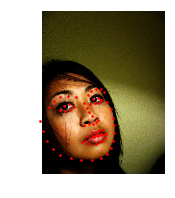

In [ ]:
img = open_image(img_fns[0])
pnts = ImagePoints(pose_pnts[0], img.size)
img.show(y=pnts)

In [ ]:
def test_tfm(x, y, tfms, **kwargs):
    tfm_x = apply_tfms(tfms, x, **kwargs)
    tfm_y = apply_tfms(tfms, y, do_resolve=False, **kwargs)
    return tfm_x, tfm_y

Pixel tranforms aren't supported for points. The only pixel transforms in fastai are `flip_lr`, `dihedral`, `crop`,  `pad` and `crop_pad`. We can implement the first two at an affine or coord level, the only downside is that it will trigger an unnecessary interpolation for the image (if we didn't need one). The last two are a bit more messy because they change the size of the image...

In [ ]:
@TfmAffine
def flip_affine() -> TfmAffine:
    return [[-1, 0, 0.],
            [0,  1, 0],
            [0,  0, 1.]]

In [ ]:
tfms = [rotate(degrees=-30)]

By default, point outs of the image are removed.

In [ ]:
tfm_x,tfm_y = test_tfm(img, pnts, tfms, padding_mode='zeros')

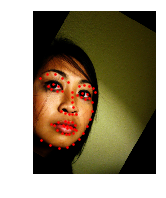

In [ ]:
tfm_x.show(y=tfm_y)

But you can change this with `remove_out=False`.

In [ ]:
tfm_x,tfm_y = test_tfm(img, pnts, tfms, padding_mode='zeros', remove_out=False)

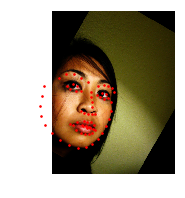

In [ ]:
tfm_x.show(y=tfm_y)

In [ ]:
def crop_coord(x, size, row_pct=0.5, col_pct=0.5):
    h,w = x.size
    rows,cols = listify(size, 2)
    x.flow.mul_(torch.Tensor([w/cols, h/rows])[None])
    row = int((h-rows+1) * row_pct)
    col = int((w-cols+1) * col_pct)
    x.flow.add_(-1 + torch.Tensor([w/cols-2*col/cols, h/rows-2*row/rows])[None])
    x.size = (rows, cols)
    return x

def pad_coord_diff(x, row_pad:int, col_pad:int, mode='zeros'):
    #TODO: implement other padding modes than zeros?
    h,w = x.size
    pad = torch.Tensor([w/(w + 2*col_pad), h/(h + 2*row_pad)])
    x.flow.mul_(pad[None])
    x.size =  (h+2*row_pad, w+2*col_pad) 
    return x

def pad_coord(x, padding, mode='reflection'):
    return pad_coord_diff(x, padding, padding, mode)

def crop_pad_coord(x, size, padding_mode='reflection', row_pct = 0.5, col_pct = 0.5):
    size = listify(size,2)
    rows,cols = size
    if x.size[0]<rows or x.size[1]<cols:
        row_pad = max((rows-x.size[0]+1)//2, 0)
        col_pad = max((cols-x.size[1]+1)//2, 0)
        x = pad_coord_diff(x, row_pad, col_pad)
    return crop_coord(x,(rows,cols), row_pct, col_pct)

In [ ]:
img.size

torch.Size([500, 375])

In [ ]:
tfms = [crop_pad(size=300, row_pct=(0.,1.), col_pct=(0.,1.))]

In [ ]:
tfm_x,tfm_y = test_tfm(img, pnts, tfms, padding_mode='zeros', size=300)

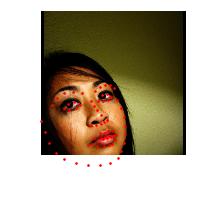

In [ ]:
tfm_x.show(y=tfm_y)

In [ ]:
#To check
@TfmAffine
def dihedral_affine(k:partial(uniform_int,0,8)):
    "Randomly flip `x` image based on `k`."
    x = -1 if k&1 else 1
    y = -1 if k&2 else 1
    if k&4: return [[0, x, 0.],
                    [y, 0, 0],
                    [0, 0, 1.]]
    return [[x, 0, 0.],
            [0, y, 0],
            [0, 0, 1.]]

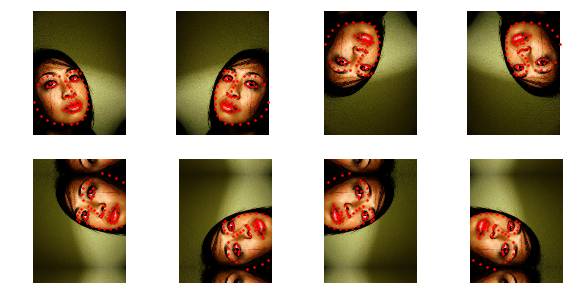

In [ ]:
_, axs = plt.subplots(2, 4, figsize=(10,5))
for i, ax in enumerate(axs.flatten()):
    tfms = [dihedral_affine(p=1)]
    tfms[0].resolved = {'k':i}
    tfm_x = apply_tfms(tfms, img, do_resolve=False)
    tfm_y = apply_tfms(tfms, pnts, do_resolve=False)
    tfm_x.show(ax=ax, y = tfm_y)

## Coord transforms (perspective warping)

Change in the current implementation to support points data augmentation.

In [ ]:
def _find_coeffs(orig_pts:Points, targ_pts:Points)->Tensor:
    "Find 8 coeff mentioned [here](https://web.archive.org/web/20150222120106/xenia.media.mit.edu/~cwren/interpolator/)."
    matrix = []
    #The equations we'll need to solve.
    for p1, p2 in zip(targ_pts, orig_pts):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = FloatTensor(matrix)
    B = FloatTensor(orig_pts).view(8)
    #The 8 scalars we seek are solution of AX = B
    return torch.gesv(B,A)[0][:,0]

def _apply_perspective(coords:FlowField, coeffs:Points)->FlowField:
    "Transform `coords` with `coeffs`."
    size = coords.size()
    #compress all the dims expect the last one ang adds ones, coords become N * 3
    coords = coords.view(-1,2)
    #Transform the coeffs in a 3*3 matrix with a 1 at the bottom left
    coeffs = torch.cat([coeffs, FloatTensor([1])]).view(3,3)
    coords = torch.addmm(coeffs[:,2], coords, coeffs[:,:2].t())
    coords.mul_(1/coords[:,2].unsqueeze(1))
    return coords[:,:2].view(size)

_orig_pts = [[-1,-1], [-1,1], [1,-1], [1,1]]

def _perspective_warp(c:FlowField, targ_pts:Points, invert=False):
    "Apply warp to `targ_pts` from `_orig_pts` to `c` `FlowField`."
    if invert: return _apply_perspective(c, _find_coeffs(targ_pts, _orig_pts))
    return _apply_perspective(c, _find_coeffs(_orig_pts, targ_pts))

@TfmCoord
def perspective_warp(c, img_size, magnitude:partial(uniform,size=8)=0, invert=False):
    "Apply warp of `magnitude` to `c`."
    magnitude = magnitude.view(4,2)
    targ_pts = [[x+m for x,m in zip(xs, ms)] for xs, ms in zip(_orig_pts, magnitude)]
    return _perspective_warp(c, targ_pts, invert)

@TfmCoord
def symmetric_warp(c, img_size, magnitude:partial(uniform,size=4)=0, invert=False):
    "Apply symmetric warp of `magnitude` to `c`."
    m = listify(magnitude, 4)
    targ_pts = [[-1-m[3],-1-m[1]], [-1-m[2],1+m[1]], [1+m[3],-1-m[0]], [1+m[2],1+m[0]]]
    return _perspective_warp(c, targ_pts, invert)

@TfmCoord
def tilt(c, img_size, direction:uniform_int, magnitude:uniform=0, invert=False):
    "Tilt `c` field with random `direction` and `magnitude`."
    orig_pts = [[-1,-1], [-1,1], [1,-1], [1,1]]
    if direction == 0:   targ_pts = [[-1,-1], [-1,1], [1,-1-magnitude], [1,1+magnitude]]
    elif direction == 1: targ_pts = [[-1,-1-magnitude], [-1,1+magnitude], [1,-1], [1,1]]
    elif direction == 2: targ_pts = [[-1,-1], [-1-magnitude,1], [1,-1], [1+magnitude,1]]
    elif direction == 3: targ_pts = [[-1-magnitude,-1], [-1,1], [1+magnitude,-1], [1,1]]
    coeffs = _find_coeffs(targ_pts, _orig_pts) if invert else _find_coeffs(_orig_pts, targ_pts)
    return _apply_perspective(c, coeffs)

@TfmCoord
def skew(c, img_size, direction:uniform_int, magnitude:uniform=0, invert=False):
    "Skew `c` field with random `direction` and `magnitude`."
    orig_pts = [[-1,-1], [-1,1], [1,-1], [1,1]]
    if direction == 0:   targ_pts = [[-1-magnitude,-1], [-1,1], [1,-1], [1,1]]
    elif direction == 1: targ_pts = [[-1,-1-magnitude], [-1,1], [1,-1], [1,1]]
    elif direction == 2: targ_pts = [[-1,-1], [-1-magnitude,1], [1,-1], [1,1]]
    elif direction == 3: targ_pts = [[-1,-1], [-1,1+magnitude], [1,-1], [1,1]]
    elif direction == 4: targ_pts = [[-1,-1], [-1,1], [1+magnitude,-1], [1,1]]
    elif direction == 5: targ_pts = [[-1,-1], [-1,1], [1,-1-magnitude], [1,1]]
    elif direction == 6: targ_pts = [[-1,-1], [-1,1], [1,-1], [1+magnitude,1]]
    elif direction == 7: targ_pts = [[-1,-1], [-1,1], [1,-1], [1,1+magnitude]]
    coeffs = _find_coeffs(targ_pts, _orig_pts) if invert else _find_coeffs(_orig_pts, targ_pts)
    return _apply_perspective(c, coeffs)

In [ ]:
tfms = [tilt(direction=(0,3), magnitude=0.4)]

In [ ]:
tfm_x,tfm_y = test_tfm(img, pnts, tfms, padding_mode='zeros', size=300)

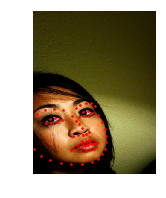

In [ ]:
tfm_x.show(y=tfm_y)

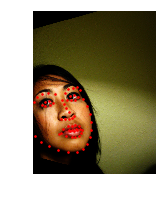

In [ ]:
tfms = [symmetric_warp(magnitude=(-0.4,0.4))]
tfm_x,tfm_y = test_tfm(img, pnts, tfms, padding_mode='zeros')
tfm_x.show(y=tfm_y)

## All at once

In [ ]:
def get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10., max_zoom:float=1.1,
                   max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75,
                   p_lighting:float=0.75, xtra_tfms:float=None)->Collection[Transform]:
    "Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms."
    res = [rand_crop()]
    if do_flip:    res.append(dihedral() if flip_vert else flip_affine(p=0.5))
    if max_warp:   res.append(symmetric_warp(magnitude=(-max_warp,max_warp), p=p_affine))
    if max_rotate: res.append(rotate(degrees=(-max_rotate,max_rotate), p=p_affine))
    if max_zoom>1: res.append(rand_zoom(scale=(1.,max_zoom), p=p_affine))
    if max_lighting:
        res.append(brightness(change=(0.5*(1-max_lighting), 0.5*(1+max_lighting)), p=p_lighting))
        res.append(contrast(scale=(1-max_lighting, 1/(1-max_lighting)), p=p_lighting))
    #       train                   , valid
    return (res + listify(xtra_tfms), [crop_pad()])

In [ ]:
tfms = get_transforms()
tfm_x, tfm_y = test_tfm(img, pnts, tfms[0], size=224)

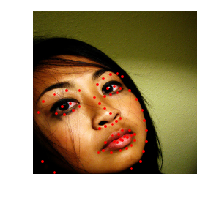

In [ ]:
tfm_x.show(y=tfm_y)